In [209]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

## Problem 1
First define the Gibbs jumping kernel
$$
J^{Gibbs}_{t, j}(\theta^*|\theta^{t-1}) = p(\theta^*_j|\theta^{t-1}_{-j})\mathbb{1}\{\theta^*_j = \theta^{t-1}_j\}
$$
Then we calculate the acceptance rate under the Metropolis-Hastings algorithm
$$
\begin{aligned}
r &= \frac{p(\theta^*)/J^{Gibbs}_{t,j}(\theta^*|\theta^{t-1})}{p(\theta^{t-1})/J^{Gibbs}_{t,j}(\theta^{t-1}|\theta^*)} \\
&= \frac{p(\theta^*)/p(\theta^*_j|\theta^{t-1}_{-j})}{p(\theta^{t-1})/p(\theta^{t-1}_j|\theta^*_{-j})} \\
&= \frac{p(\theta^{t-1}_{-j})}{p(\theta^{t-1}_{-j})} \\
&= 1
\end{aligned}
$$
So every jump is accepted under the Gibbs jumping kernel, which turns out to be the Gibbs Sampling algorithm.

## Problem 2
It's easy to see that $A\mathbb{1} = \mathbb{1}$, so 1 is an eigenvalue of $A$

## Problem 3
##### (1)
$$
\Sigma = \begin{pmatrix}
\sigma_1^2 & \rho\sigma_1\sigma_2 \\
\rho\sigma_1\sigma_2 & \sigma_2^2
\end{pmatrix}
$$
$$
\Sigma^{-1} = \begin{pmatrix}
\frac{1}{(1-\rho^2)\sigma_1^2} & -\frac{\rho}{(1-\rho^2)\sigma_1\sigma_2} \\
-\frac{\rho}{(1-\rho^2)\sigma_1\sigma_2} & \frac{1}{(1-\rho^2)\sigma_2^2}
\end{pmatrix}
$$
$$
|\Sigma| = (1-\rho^2)\sigma_1^2\sigma_2^2
$$
$$
p(x, y) \propto \exp\{ -(x, y)\Sigma^{-1}(x,y)^T \}
$$
$$
p(x|y) \propto C(y)\exp\{ -\frac{1}{(1-\rho^2)\sigma_1^2}(x-\frac{\rho\sigma_1}{\sigma_2}y)^2 \}
$$
$$
p(y|x) \propto C(x)\exp\{ -\frac{1}{(1-\rho^2)\sigma_2^2}(y-\frac{\rho\sigma_2}{\sigma_1}x)^2 \}
$$
so
$$
p(x|y) = \mathcal{N}(\frac{\rho\sigma_1}{\sigma_2}y, (1-\rho^2)\sigma_1^2)
$$
$$
p(y|x) = \mathcal{N}(\frac{\rho\sigma_2}{\sigma_1}x, (1-\rho^2)\sigma_2^2)
$$

##### (2)
Let
$
\sigma_1 = 2, \sigma_2 = 1
$
we have
$$
p(x|y) = \mathcal{N}(2\rho y, 4(1-\rho^2))
$$
$$
p(y|x) = \mathcal{N}(\frac{\rho}{2}x, 1-\rho^2)
$$

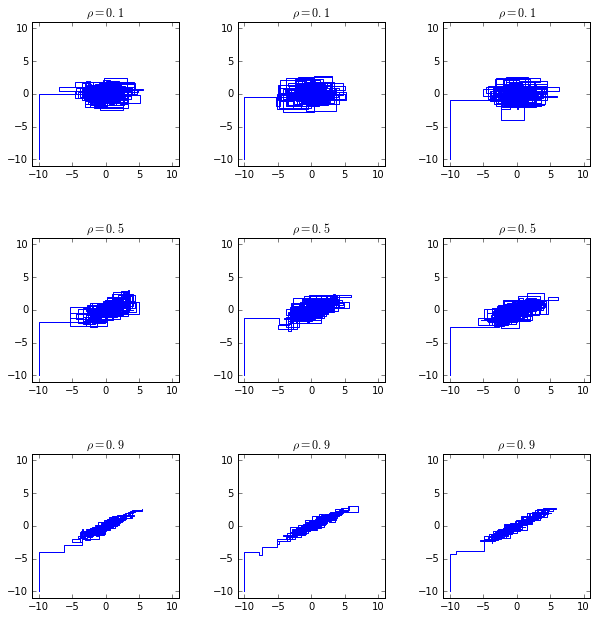

In [210]:
def cond_x_given_y(rho, y):
    return 2*rho*y, np.sqrt(4*(1 - rho**2))

def cond_y_given_x(rho, x):
    return rho/2.0*x, np.sqrt(1 - rho**2)

def problem_11_3(rho, jumps=100):
    x, y = -10., -10.
    trace = [(-10., -10.)]
    for jump in xrange(jumps):
        y_mu, y_sigma = cond_y_given_x(rho, x)
        y = np.random.normal(y_mu, y_sigma, size=1)
        trace.append((x, y))
        x_mu, x_sigma = cond_x_given_y(rho, y)
        x = np.random.normal(x_mu, x_sigma, size=1)
        trace.append((x, y))
    return trace

from collections import defaultdict
traces = defaultdict(list)
rhos = [0.1, 0.5, 0.9]
chains = 3
fig = plt.figure(figsize=(10, 10))
for i, rho in enumerate(rhos):
    for chain in xrange(chains):
        trace = problem_11_3(rho, 300)
        trace = np.array(trace)
        traces[rho].append(trace)
        ax = fig.add_subplot(3, 3, i*3 + chain + 1)
        ax.plot(trace[:, 0], trace[:, 1])
        ax.set_title(r'$\rho = %s$' % rho)
        ax.set_xlim(-11, 11)
        ax.set_ylim(-11, 11)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

##### (3)
We calculate potential scale reduction for $x$ and $y$ below, discarding the first half of the simulation and cutting the second halves into 6 chains for each $\rho$

In [211]:
var_est_x = []
for rho in rhos:
    chains = np.array(traces[rho])
    chains = chains[:, int(chains.shape[1]/2. + 1):, :]
    split_chains = chains.reshape((-1, int(chains.shape[1]/2), 2))
    m, n, _ = split_chains.shape
    chain_mean = split_chains.mean(axis=1, keepdims=True)
    total_mean = chain_mean.mean(axis=0, keepdims=True)
    B = n / (m - 1) * ((chain_mean - total_mean)**2).sum(axis=(0, 1))
    W = np.mean(1./(n - 1) * ((split_chains - chain_mean)**2).sum(axis=1), axis=0)
    var_est = (n - 1.)/n * W + 1./n * B
    var_est_x.append(var_est[0])
    R_est = np.sqrt(var_est / W)
    print 'rho=%s: R_x=%s, R_y=%s' % tuple([rho] + R_est.tolist())

rho=0.1: R_x=1.00381410659, R_y=1.00305929616
rho=0.5: R_x=0.999680790569, R_y=1.0043901105
rho=0.9: R_x=1.05913007799, R_y=1.06340157381


We can see that the $\hat{R}$ is smaller than 1.1 both for x and y, which concludes that the chains are mixing well.

##### (4)


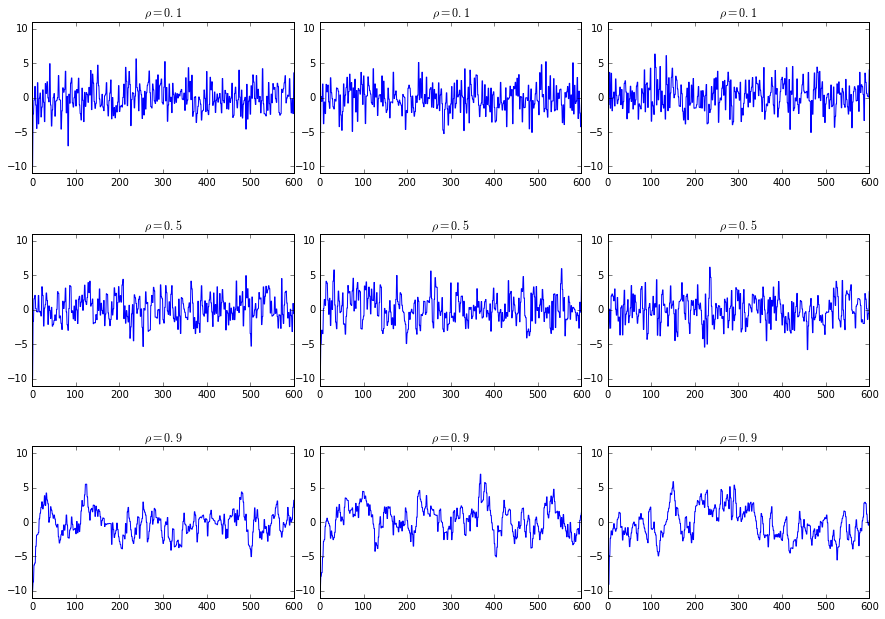

In [212]:
chains = 3
fig = plt.figure(figsize=(15, 10))
for i, rho in enumerate(rhos):
    for chain in xrange(chains):
        trace_x = traces[rho][chain][:, 0]
        ax = fig.add_subplot(3, 3, i*3 + chain + 1)
        ax.plot(np.arange(trace_x.shape[0]), trace_x)
        ax.set_title(r'$\rho = %s$' % rho)
        ax.set_ylim(-11, 11)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)

According to the marginal trace plots of $X$, the number of iterations that Gibbs needs to converge is around 50.

##### (5)
After the warm-up period, the variance of a single chain is approximately equal to the variance estimate. So we use the variance estimate we get from (3)

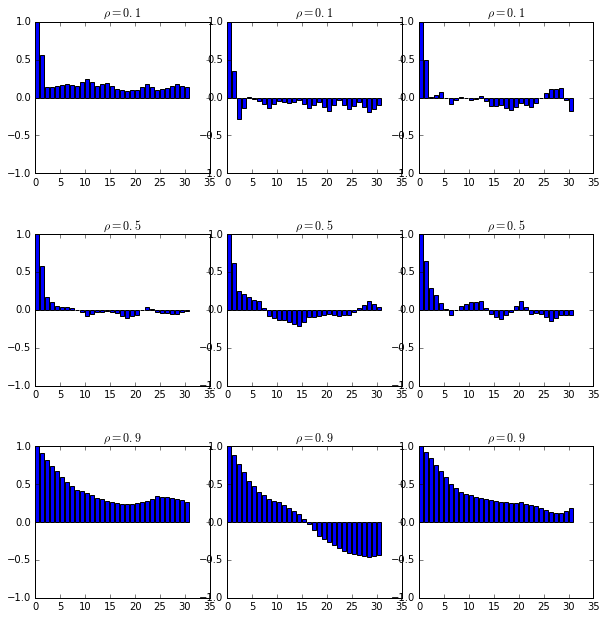

In [213]:
def auto_correlation(a, t, var):
    a = np.array(a)
    n = a.shape[0]
    if n <= t:
        print 'lag too long'
        return 0
    elif t == 0:
        return 1.0
    vt = np.mean((a[t:] - a[:(-t)])**2)
    return 1. - vt/(2*var)

chains = 3
fig = plt.figure(figsize=(10, 10))
for i, rho in enumerate(rhos):
    for chain in xrange(chains):
        trace_x = traces[rho][chain][:, 0]
        trace_x = trace_x[int(trace_x.shape[0]/2. + 1):]
        corr = [auto_correlation(trace_x, t, var_est_x[i]) for t in xrange(31)]
        ax = fig.add_subplot(3, 3, i*3 + chain + 1)
        ax.bar(np.arange(31), corr)
        ax.set_title(r'$\rho = %s$' % rho)
        ax.set_ylim(-1, 1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)

## Problem 4

##### (1)
Let $\sigma_1=\sigma_2=1$, $\rho=0.5$, we get
$$
p(x, y) = \mathcal{N}(
\begin{pmatrix}
0 \\
0
\end{pmatrix},
\begin{pmatrix}
1 & 0.5\\
0.5 & 1
\end{pmatrix})
$$

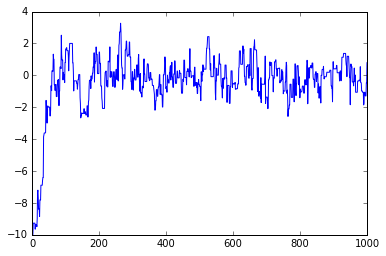

In [214]:
def problem_11_4(k_sigma, jumps=100):
    sigma = np.array([[1, 0.5],
                      [0.5, 1]])
    cur = np.array([-10., -10.])
    trace = [cur,]
    p_cur = stats.multivariate_normal.pdf(cur, [0, 0], sigma)
    for jump in xrange(jumps):
        _next = np.random.multivariate_normal(cur, k_sigma, size=1)[0]
        p_jump = stats.multivariate_normal.pdf(_next, cur, np.eye(2))
        p_next = stats.multivariate_normal.pdf(_next, [0, 0], sigma)
        p_back = stats.multivariate_normal.pdf(cur, _next, np.eye(2))
        acc_rate = (p_next / p_jump) / (p_cur / p_back)
        if np.random.uniform() <= acc_rate:
            cur = _next
            p_cur = p_next
        trace.append(cur)
    return trace

def draw_11_4(k_sigma):
    from collections import defaultdict
    traces = defaultdict(list)
    plt.figure()
    trace = problem_11_4(k_sigma, 1000)
    trace_x = np.array(trace)[:, 0]
    plt.plot(np.arange(trace_x.shape[0]), trace_x)

draw_11_4(np.eye(2))

##### (2)

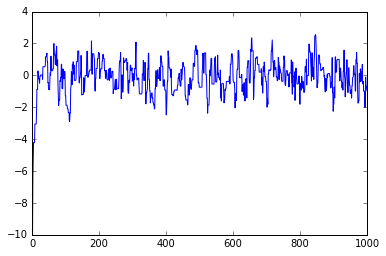

In [215]:
draw_11_4(np.array([[1, 0.5],
                    [0.5, 1]]))

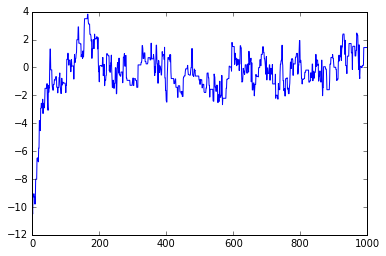

In [216]:
draw_11_4(np.array([[1, -0.5],
                    [-0.5, 1]]))

##### (3)

We can see that when the random jump kernel is following the landscape of the target density (as in the second graph), the convergence of the chain is much faster, while if not, the convergence is relatively slow as in the last graph.